# Description

Vi har här skapat en PC builder som söker fram optimala PC builds baserat på det data vi har samlat från olika nätbutiker i olika delar av världen. Systemet tar i beaktande priset av produkten samt hur bra själva produkten är och försöker sedan hitta den bästa builden baserat på pris och quality. Tull och frakt räknas också in i kostnaden så användaren vet det totala priset som måste betalas, och det inte finns några surprise expenses. 
<br><br>
Varje gång programmet körs, skapas rea priser slumpmässigt för de olika produkterna för att simulera Black Friday priser.

In [1]:
import time
import random
import matplotlib.pyplot as plt
from functools import partial
import numpy as np
from typing import List,Callable,Tuple

# Använder type hinting för att kanske göra koden lite 
# enklare att läsa och förstå. Hoppas det inte har den 
# motsatta effekten.

# Types för populationen och genome
Genome = List[int]
Population = List[Genome]

# Callable functions som passas in som argument för att göra programmet mera generalized
FitnessFunc = Callable[[Genome], int]
PopulateFunc = Callable[[], Population]
SelectionFunc = Callable[[Population, FitnessFunc], Tuple[Genome,Genome]]
CrossoverFunc = Callable[[Genome,Genome], Tuple[Genome,Genome]]
MutationFunc = Callable[[Genome],Genome]

class PCBuilder():
    def __init__(self):
        self.sales = None
        self.parts = self.initValues()
        
        
    # Initiates values for parts
    def initValues(self):
        parts = [
        #1.verkkokauppa 2. jimms 3. newegg 4. amazon 5. aliexpress 6. mindfactory.de, 7.box.co.uk, 8.microcenter 9.alibaba 10.caseking.de
        [(350,1.0),(170,0.6),(219,0.7),(227,0.8),(152,0.4),(212,0.8),(330,0.9),(380,0.95),(70,0.3),(260,0.8)],#mobo
        [(340,0.7),(500,0.85),(300,0.6),(520,0.9),(275,0.6),(158,0.2),(320,0.75),(309,0.75),(6200,1.0),(500,0.8)], #cpu
        [(1900,0.95),(809,0.7),(375,0.2),(488,0.5),(390,0.2),(666,0.8),(750,0.65),(795,0.8),(883,0.75),(513,0.5)], #gpu
        [(78,0.4),(180,0.8),(120,0.8),(280,0.95),(45,0.2),(87,0.7),(82,0.5),(97,0.9),(38,0.2),(110,0.7)], #ram
        [(329,0.8),(55,0.1),(92,0.5),(54,0.1),(25,0.1),(224,0.8),(150,0.6),(180,0.7),(24,0.15),(142,0.7)],#hd
        [(215,0.8),(83,0.6),(119,0.7),(105,0.8),(43,0.05),(148,0.85),(81,0.7),(66,0.7),(35,0.1),(211,0.9)],#case
        [(150,0.8),(63,0.2),(100,0.8),(77,0.45),(150,0.85),(137,0.8),(218,0.9),(49,0.4),(80,0.5),(150,0.85)]#power supply
        ]
        [1, 7, 9, 7, 3, 1, 0]
        self.sales = [[random.uniform(0.3, 0.9) if random.randint(0, 1) == 1 else 1 for _ in k] for k in np.ones((7, 10))]
        parts = [[(parts[k][p][0]*self.sales[k][p],parts[k][p][1]) for p in range(len(parts[k]))] for k in range(len(parts))] # Readability +1

        return parts

    # Genererar en genome
    def generateGenome(self, l: int):
        return [random.randrange(0,10) for _ in range(l)] 

    # Genererar en start population 
    def generatePopulation(self, size: int,length: int):
        return [self.generateGenome(length) for i in range(size)] 

    # Testar fitness av genome
    def testFitness(self, genome: Genome, costOnly: bool = False):
        parts = self.parts
        customs = [0,0,60,0,30,60,50,0,30,0]
        shipping = [30,20,70,40,60,30,40,20,60,30]
        shops = [0,0,0,0,0,0,0,0,0,0]
        cost = 0
        if costOnly: 
            for i in range(len(genome)):
                for j in range(len(shops)):
                    if genome[i] == j:
                        cost += parts[i][j][0]
                        shops[j] = 1
        else:    
            for i in range(len(genome)):
                for j in range(len(shops)):
                    if genome[i] == j:
                        cost += parts[i][j][0]/(parts[i][j][1]*10)
                        shops[j] = 1

        for i in range(len(shops)):
            if shops[i] == 1:
                cost += shipping[i]
                cost += customs[i]
        return cost
    
    # Testar fitness av genome
    def testFitnessQL(self, genome: Genome):
        parts = self.parts
        customs = [0,0,60,0,30,60,50,0,30,0]
        shipping = [30,20,70,40,60,30,40,20,60,30]
        shops = [0,0,0,0,0,0,0,0,0,0]
        cost = 0
        quality = 0
        for i in range(len(genome)):
            for j in range(len(shops)):
                if genome[i] == j:
                    cost += parts[i][j][0]
                    quality += parts[i][j][1]
                    shops[j] = 1
                    
        if quality/len(genome) < self.qualityLimit:
            return 99999
        
        for i in range(len(shops)):
            if shops[i] == 1:
                cost += shipping[i]
                cost += customs[i]
        return cost

    # Väljer ett par från populationen
    def selectionPair(self, pop: Population, fitnessFunc: FitnessFunc):
        return(random.choices(population=pop,
                      weights=[fitnessFunc(g) for g in pop],
                      k=2))

    # Single point crossover mellan två genomes
    def singlePointCrossover(self, a: Genome, b: Genome):
        p = random.randint(2,len(a)-1)
        return a[0:p] + b[p:],b[0:p] + a[p:]

    # Muterar en genome med 10% sannolikhet
    def mutation(self, genome: Genome, num: int = 1, probability: float = 0.1) -> Genome:
        for _ in range(num):
            i = random.randrange(len(genome))
            genome[i] = genome[i] if random.random() > probability else random.randrange(1,3)
        return genome

    # Start
    # Tar emot alla specified functions för ett problem och 
    def runEvolution(self, populateFunc: PopulateFunc,
                     fitnessFunc: FitnessFunc,
                     limit: int,
                     qualityLimit: int = None,
                     selectionFunc: SelectionFunc = selectionPair,
                     crossoverFunc: CrossoverFunc = singlePointCrossover,
                     mutationFunc: MutationFunc = mutation,
                     generationLimit = 100) -> Tuple[Population, int]:

        self.qualityLimit = qualityLimit
        bests = []
        population = populateFunc()                                             # Generera en population och kör igenom
        for i in range(generationLimit):                                        #  alla generationer tills fitness blir  
            population = sorted(population,                                     #  tillräckligt bra, eller tills den slår 
                                key=lambda genome: fitnessFunc(genome),         #  generationLimit som är given av function
                                reverse = False)                                #  caller.
            if fitnessFunc(population[0]) < limit:
                break

            bests.append(fitnessFunc(population[0]))
            nextGeneration = population[0:2]                                    # Ta de två bästa till nästa generation.
            for j in range(int(len(population) / 2) - 1):                       
                parents = selectionFunc(population, fitnessFunc)                # Välj 2 parents by random 
                offspringA, offspringB = crossoverFunc(parents[0],parents[1])   # Gör singlepoint crossover mellan parents
                offspringA = mutationFunc(offspringA)                           # Gör möjlig mutation för båda offsprings
                offspringB = mutationFunc(offspringB)
                nextGeneration += [offspringA,offspringB]                       # Lägg till offsprings till nästa generation
            population = nextGeneration
        
        
        population = sorted(population,
                            key=lambda genome: fitnessFunc(genome),
                            reverse = False)
        return population,i+1,bests                                                   # Returnera generations required och fem
                                                                                # bästa solutions.




## 1. Building a pc with that has an optimal price to quality ratio

Generations needed: 100
Best solutions:

Price: $ 1542.16
Objective cost:  252.08
Configuration: [9, 1, 1, 1, 9, 1, 9]

Price: $ 1542.16
Objective cost:  252.08
Configuration: [9, 1, 1, 1, 9, 1, 9]

Price: $ 1572.44
Objective cost:  433.94
Configuration: [9, 1, 1, 1, 1, 4, 9]

Price: $ 1613.8
Objective cost:  442.95
Configuration: [9, 1, 1, 1, 9, 4, 1]

Price: $ 1020.33
Objective cost:  520.84
Configuration: [9, 1, 2, 1, 1, 4, 2]

Price: $ 3915.05
Objective cost:  574.78
Configuration: [1, 8, 1, 1, 9, 1, 9]

Price: $ 3322.0
Objective cost:  655.12
Configuration: [2, 8, 2, 1, 2, 1, 9]

Price: $ 3312.03
Objective cost:  673.94
Configuration: [2, 8, 2, 1, 9, 1, 1]

Price: $ 3894.82
Objective cost:  748.31
Configuration: [1, 8, 1, 1, 1, 4, 1]

Price: $ 3945.33
Objective cost:  756.64
Configuration: [1, 8, 1, 1, 1, 4, 9]


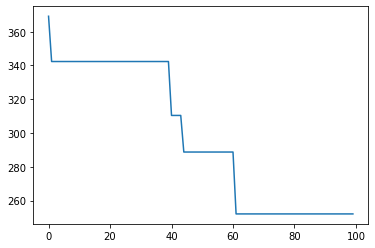

In [2]:
builder = PCBuilder()
population, gens, curve = builder.runEvolution(populateFunc = partial(builder.generatePopulation,size=50,length=7),
                                fitnessFunc = builder.testFitness,
                                selectionFunc = builder.selectionPair,
                                crossoverFunc = builder.singlePointCrossover,
                                mutationFunc = builder.mutation,
                                limit = 1,
                                generationLimit = 100)

#print(builder.sales)
options = [(round(builder.testFitness(x,costOnly=True),2),x) for x in population[:10]]
objCost = [(round(builder.testFitness(x),2)) for x in population[:10]]
print(f"Generations needed: {gens}")
print(f"Best solutions:")
for i in range(len(options)):
    print("\nPrice: $",options[i][0])
    print("Objective cost: ",objCost[i])
    print("Configuration:",population[i])

plt.plot(curve)
plt.show()

## 2. Building a pc with a quality limit for the lowest price

Generations needed: 16
Best solutions:

Price: $ 1354.79
Configuration: [3, 7, 5, 1, 9, 9, 0]

Price: $ 1518.63
Configuration: [0, 9, 3, 9, 9, 0, 2]

Price: $ 1524.7
Configuration: [6, 6, 3, 9, 0, 0, 4]

Price: $ 2083.4
Configuration: [2, 3, 1, 2, 9, 5, 2]

Price: $ 2250.72
Configuration: [5, 1, 1, 2, 5, 5, 2]

Price: $ 2279.24
Configuration: [7, 7, 1, 3, 6, 9, 0]

Price: $ 2892.19
Configuration: [2, 3, 0, 6, 6, 5, 0]

Price: $ 2985.51
Configuration: [2, 3, 0, 6, 0, 5, 6]

Price: $ 7469.84
Configuration: [2, 8, 3, 9, 9, 5, 5]

Price: $ 7912.9
Configuration: [2, 8, 1, 2, 2, 5, 0]


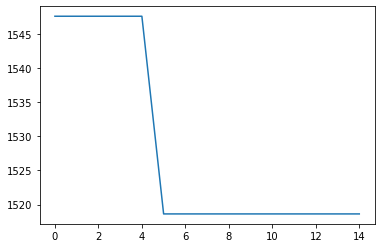

In [4]:
builder = PCBuilder()
population, gens, curve = builder.runEvolution(populateFunc = partial(builder.generatePopulation,size=250,length=7),
                                fitnessFunc = builder.testFitnessQL,
                                selectionFunc = builder.selectionPair,
                                crossoverFunc = builder.singlePointCrossover,
                                mutationFunc = builder.mutation,
                                limit = 1400,
                                qualityLimit = 0.75,
                                generationLimit = 200)

#print(builder.sales)
cost = [(round(builder.testFitnessQL(x),2)) for x in population]

print(f"Generations needed: {gens}")
print(f"Best solutions:")
for i in range(len(options)):
    print("\nPrice: $",cost[i])
    print("Configuration:",population[i])

plt.plot(curve)
plt.show()